In [12]:
# pip install "numpy<2"
# pip install catboost
# !pip install optuna

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split  
import optuna

In [3]:
## Read dataset

df = pd.read_csv("/data/ksa/00_Data_Input/relabelled_data_ksa_explore.csv")
print(df.shape)
print(df.columns)
df.head()

(3835, 59)
Index(['idpoint', 'idsubsegment', 'idsegment', 'nth', 'periode', 'observation',
       'MGRS', 'VH_0', 'VH_1', 'VH_2', 'VH_3', 'VH_4', 'VH_5', 'VH_6', 'VH_7',
       'VH_8', 'VH_9', 'VH_10', 'VH_11', 'VH_12', 'VH_13', 'VH_14', 'VH_15',
       'VH_16', 'VH_17', 'VH_18', 'VH_19', 'VH_20', 'VH_21', 'VH_22', 'VH_23',
       'VH_24', 'VH_25', 'VH_26', 'VH_27', 'VH_28', 'VH_29', 'VH_30', 'F1',
       'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'F11', 'F12',
       'F13', 'F14', 'F15', 'F16', 'F17', 'class', 'bulan', 'tahun', 'idkab'],
      dtype='object')


,idpoint,idsubsegment,idsegment,nth,periode,observation,MGRS,VH_0,VH_1,VH_2,...,F12,F13,F14,F15,F16,F17,class,bulan,tahun,idkab
0,320101008b1#01,320101008b1,320101008,9,2022_30,6.0,48MYU,-1387,-1368,-1351,...,1.000000,0.785398,-31.000000,-1.538549,-217.9999999999,-1.5662092030054973,NP,9,2022,3201
1,320101008b1#01,320101008b1,320101008,10,2023_03,6.0,48MYU,-1434,-1415,-1377,...,1.000000,0.785398,-18.777778,-1.517592,-232.9999999999,-1.5665045076528836,NP,10,2023,3201
2,320101008b2#01,320101008b2,320101008,4,2022_18,6.0,48MYU,-948,-1098,-1398,...,105.600000,1.561327,1.000000,0.785398,440.0000000001,1.5685236034352557,NP,4,2022,3201
3,320101008b2#01,320101008b2,320101008,5,2022_20,5.0,48MYU,-1424,-1248,-948,...,7.428571,1.436985,-238.000000,-1.566595,-83.9999999999,-1.5588921272365726,PL,5,2022,3201
4,320101008b2#01,320101008b2,320101008,12,2023_07,6.0,48MYU,-1479,-1438,-1356,...,10.600000,1.476735,-61.500000,-1.554538,-100.9999999999,-1.5608956602068982,NP,12,2023,3201


In [4]:
df['F10'] = df['F10'].str.replace(',', '.').astype(float)
df['F11'] = df['F11'].str.replace(',', '.').astype(float)
df['F16'] = df['F16'].str.replace(',', '.').astype(float)
df['F17'] = df['F17'].str.replace(',', '.').astype(float)

In [6]:
def get_train__test(df, test_size, condition="backscatter"):
    # Make X and Y dataset
    y = df.observation
    if(condition=="backscatter"):
        X = df.loc[:,'VH_0':'VH_30']
    elif(condition=="features"):
        X = df.loc[:,'F1':'F17']
    else:
        X = df.loc[:,'VH_0':'F17']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)
    return X_train, X_test, y_train, y_test

In [8]:
def objective(trial):
    param = {
        "iterations": trial.suggest_int("iterations", 100, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1.0),
        "depth": trial.suggest_int("depth", 1, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-8, 10.0),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "random_strength": trial.suggest_float("random_strength", 1e-8, 10.0),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 1e-8, 1.0),
        "verbose": 0
    }

    # Use Stratified K-Fold cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cat_clf = CatBoostClassifier(**param)

    scores = cross_val_score(cat_clf, X_train, y_train, cv=skf, scoring='accuracy')
    accuracy = scores.mean()
    
    return accuracy


# Split dataset

In [7]:
X_train, X_test, y_train, y_test = get_train__test(df, 0.2, condition="backscatter")
# X_train, X_test, y_train, y_test = get_train__test(df, 0.2, condition="features")

## Backscatter

base model Accuracy: 0.5658

Best parameters found by Optuna: {'iterations': 746, 'learning_rate': 0.025663170288742786, 'depth': 10, 'l2_leaf_reg': 9.05638073650341, 'border_count': 75, 'random_strength': 0.9561729796162401, 'bagging_temperature': 0.4875062592104879}

best model Accuracy: 0.5711

In [10]:
# Initialize the CatBoostClassifier
base_model = CatBoostClassifier(iterations=100,
                           learning_rate=0.1,
                           depth=6,
                           verbose=0)

# Train the model
base_model.fit(X_train, y_train)


In [17]:
# Evaluate the model on the test set
y_pred = base_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

y_pred_prob = base_model.predict_proba(X_test)
y_pred_prob = np.argmax(y_pred_prob, axis=1) 
accuracy = accuracy_score(y_test, y_pred_prob)

Test Accuracy: 0.5658


In [10]:
# Create a study object and optimize
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

# Best parameters
best_params = study.best_params
print("Best parameters found by Optuna:", best_params)


[I 2024-08-19 14:03:17,513] A new study created in memory with name: no-name-9d24b782-254d-4fea-9e95-c3d8e7d6747b
[I 2024-08-19 14:09:39,911] Trial 0 finished with value: 0.5691000100961258 and parameters: {'iterations': 600, 'learning_rate': 0.09082542134772546, 'depth': 10, 'l2_leaf_reg': 2.3370216505296484, 'border_count': 56, 'random_strength': 1.8115602326777376, 'bagging_temperature': 0.15615035289349208}. Best is trial 0 with value: 0.5691000100961258.
[I 2024-08-19 14:10:19,525] Trial 1 finished with value: 0.5540998241148621 and parameters: {'iterations': 446, 'learning_rate': 0.6261862051180516, 'depth': 4, 'l2_leaf_reg': 5.37683130822876, 'border_count': 161, 'random_strength': 5.074843951077248, 'bagging_temperature': 0.34385454949218425}. Best is trial 0 with value: 0.5691000100961258.
[I 2024-08-19 14:10:50,247] Trial 2 finished with value: 0.5430243741730475 and parameters: {'iterations': 414, 'learning_rate': 0.8248548401482154, 'depth': 3, 'l2_leaf_reg': 4.658261478263

Best parameters found by Optuna: {'iterations': 746, 'learning_rate': 0.025663170288742786, 'depth': 10, 'l2_leaf_reg': 9.05638073650341, 'border_count': 75, 'random_strength': 0.9561729796162401, 'bagging_temperature': 0.4875062592104879}


In [11]:
# Best parameters
best_params = study.best_value
print("Best value found by Optuna:", best_params)

# Best parameters
best_params = study.best_params
print("Best parameters found by Optuna:", best_params)

Best value found by Optuna: 0.5827887624806714
Best parameters found by Optuna: {'iterations': 746, 'learning_rate': 0.025663170288742786, 'depth': 10, 'l2_leaf_reg': 9.05638073650341, 'border_count': 75, 'random_strength': 0.9561729796162401, 'bagging_temperature': 0.4875062592104879}


In [19]:
# Train final model on entire training data with best parameters

# best_model = CatBoostClassifier(**best_params)

best_model = CatBoostClassifier(iterations= 746, 
learning_rate= 0.025663170288742786, 
depth= 10, 
l2_leaf_reg= 9.05638073650341,
border_count= 75, 
random_strength= 0.9561729796162401, 
bagging_temperature= 0.4875062592104879)
best_model.fit(X_train, y_train)

0:	learn: 2.0639212	total: 78.6ms	remaining: 58.6s
1:	learn: 2.0497245	total: 118ms	remaining: 44s
2:	learn: 2.0348634	total: 155ms	remaining: 38.4s
3:	learn: 2.0226560	total: 188ms	remaining: 34.8s
4:	learn: 2.0066097	total: 221ms	remaining: 32.8s
5:	learn: 1.9930189	total: 245ms	remaining: 30.2s
6:	learn: 1.9765370	total: 274ms	remaining: 28.9s
7:	learn: 1.9655110	total: 301ms	remaining: 27.8s
8:	learn: 1.9528458	total: 332ms	remaining: 27.2s
9:	learn: 1.9402497	total: 358ms	remaining: 26.3s
10:	learn: 1.9255584	total: 387ms	remaining: 25.9s
11:	learn: 1.9136966	total: 415ms	remaining: 25.4s
12:	learn: 1.9017817	total: 443ms	remaining: 25s
13:	learn: 1.8884845	total: 471ms	remaining: 24.6s
14:	learn: 1.8769086	total: 501ms	remaining: 24.4s
15:	learn: 1.8624764	total: 531ms	remaining: 24.2s
16:	learn: 1.8528656	total: 558ms	remaining: 23.9s
17:	learn: 1.8426701	total: 586ms	remaining: 23.7s
18:	learn: 1.8329516	total: 615ms	remaining: 23.5s
19:	learn: 1.8226589	total: 648ms	remaining:

In [22]:
predictions = best_model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(f"Test Accuracy: {accuracy:.4f}")

y_pred_prob = best_model.predict_proba(X_test)
y_pred_prob = np.argmax(y_pred_prob, axis=1) 
accuracy = accuracy_score(y_test, y_pred_prob)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.5711
Test Accuracy: 0.5711


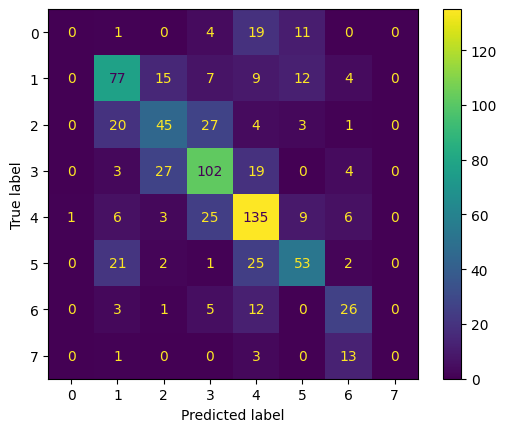

In [23]:
cm = confusion_matrix(y_test, predictions)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix = cm).plot()
plt.show()

## Features

base model Accuracy: 0.5411

Best parameters found by Optuna: {'iterations': 616, 'learning_rate': 0.16520111364339346, 'depth': 1, 'l2_leaf_reg': 2.459008641008764, 'border_count': 241, 'random_strength': 4.506655337743892, 'bagging_temperature': 0.34351896295635426}

best model Accuracy: 0.5541

In [34]:
# Initialize the CatBoostClassifier
base_model = CatBoostClassifier(iterations=100,
                           learning_rate=0.1,
                           depth=6,
                           verbose=0)

# Train the model
base_model.fit(X_train, y_train)


In [35]:
# Evaluate the model on the test set
y_pred = base_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")


y_pred_prob = best_model.predict_proba(X_test)
y_pred_prob = np.argmax(y_pred_prob, axis=1) 
accuracy = accuracy_score(y_test, y_pred_prob)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.5411


In [36]:
# Create a study object and optimize
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

# Best parameters
best_params = study.best_params
print("Best parameters found by Optuna:", best_params)


[I 2024-08-19 14:40:53,961] A new study created in memory with name: no-name-64b7b8e0-e162-47c6-ad53-ace1ea594099
[I 2024-08-19 14:41:33,859] Trial 0 finished with value: 0.5570367339564591 and parameters: {'iterations': 649, 'learning_rate': 0.17895332264100636, 'depth': 4, 'l2_leaf_reg': 9.484153971491475, 'border_count': 93, 'random_strength': 2.573284732372063, 'bagging_temperature': 0.12823960788399694}. Best is trial 0 with value: 0.5570367339564591.
[I 2024-08-19 14:42:30,991] Trial 1 finished with value: 0.5296682625630342 and parameters: {'iterations': 929, 'learning_rate': 0.5061782628135044, 'depth': 4, 'l2_leaf_reg': 1.6804899689609123, 'border_count': 104, 'random_strength': 0.6234333331380664, 'bagging_temperature': 0.3271318689848625}. Best is trial 0 with value: 0.5570367339564591.
[I 2024-08-19 14:43:01,767] Trial 2 finished with value: 0.554760854663613 and parameters: {'iterations': 358, 'learning_rate': 0.11874109959126251, 'depth': 5, 'l2_leaf_reg': 2.6688452368478

Best parameters found by Optuna: {'iterations': 616, 'learning_rate': 0.16520111364339346, 'depth': 1, 'l2_leaf_reg': 2.459008641008764, 'border_count': 241, 'random_strength': 4.506655337743892, 'bagging_temperature': 0.34351896295635426}


In [37]:
# Best parameters
best_params = study.best_value
print("Best value found by Optuna:", best_params)

# Best parameters
best_params = study.best_params
print("Best parameters found by Optuna:", best_params)

Best value found by Optuna: 0.5674702828509334
Best parameters found by Optuna: {'iterations': 616, 'learning_rate': 0.16520111364339346, 'depth': 1, 'l2_leaf_reg': 2.459008641008764, 'border_count': 241, 'random_strength': 4.506655337743892, 'bagging_temperature': 0.34351896295635426}


In [38]:
# Train final model on entire training data with best parameters
best_model = CatBoostClassifier(**best_params)
best_model.fit(X_train, y_train)

0:	learn: 1.9772991	total: 21.3ms	remaining: 13.1s
1:	learn: 1.8898438	total: 24.3ms	remaining: 7.45s
2:	learn: 1.8334022	total: 26.5ms	remaining: 5.42s
3:	learn: 1.7748641	total: 28.3ms	remaining: 4.34s
4:	learn: 1.7440423	total: 33.3ms	remaining: 4.07s
5:	learn: 1.7230294	total: 40.3ms	remaining: 4.1s
6:	learn: 1.6866211	total: 47.6ms	remaining: 4.14s
7:	learn: 1.6549884	total: 50.3ms	remaining: 3.82s
8:	learn: 1.6345655	total: 54.3ms	remaining: 3.66s
9:	learn: 1.6094143	total: 56.5ms	remaining: 3.42s
10:	learn: 1.5926597	total: 59ms	remaining: 3.24s
11:	learn: 1.5722784	total: 62ms	remaining: 3.12s
12:	learn: 1.5606653	total: 71.8ms	remaining: 3.33s
13:	learn: 1.5486383	total: 75.5ms	remaining: 3.25s
14:	learn: 1.5237601	total: 84.3ms	remaining: 3.38s
15:	learn: 1.5121707	total: 86.2ms	remaining: 3.23s
16:	learn: 1.5023095	total: 88.1ms	remaining: 3.1s
17:	learn: 1.4941796	total: 89.8ms	remaining: 2.98s
18:	learn: 1.4864680	total: 96ms	remaining: 3.02s
19:	learn: 1.4812587	total: 98

In [39]:
predictions = best_model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.5541


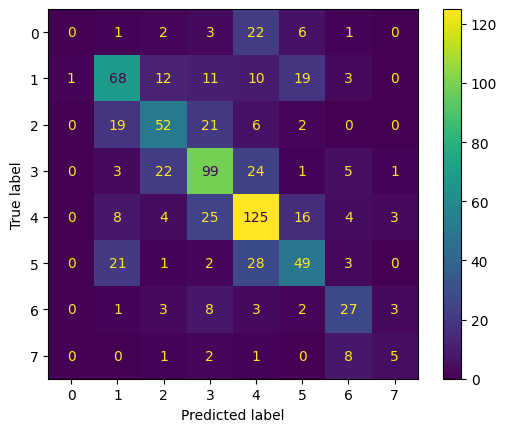

In [40]:
cm = confusion_matrix(y_test, predictions)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix = cm).plot()
plt.show()